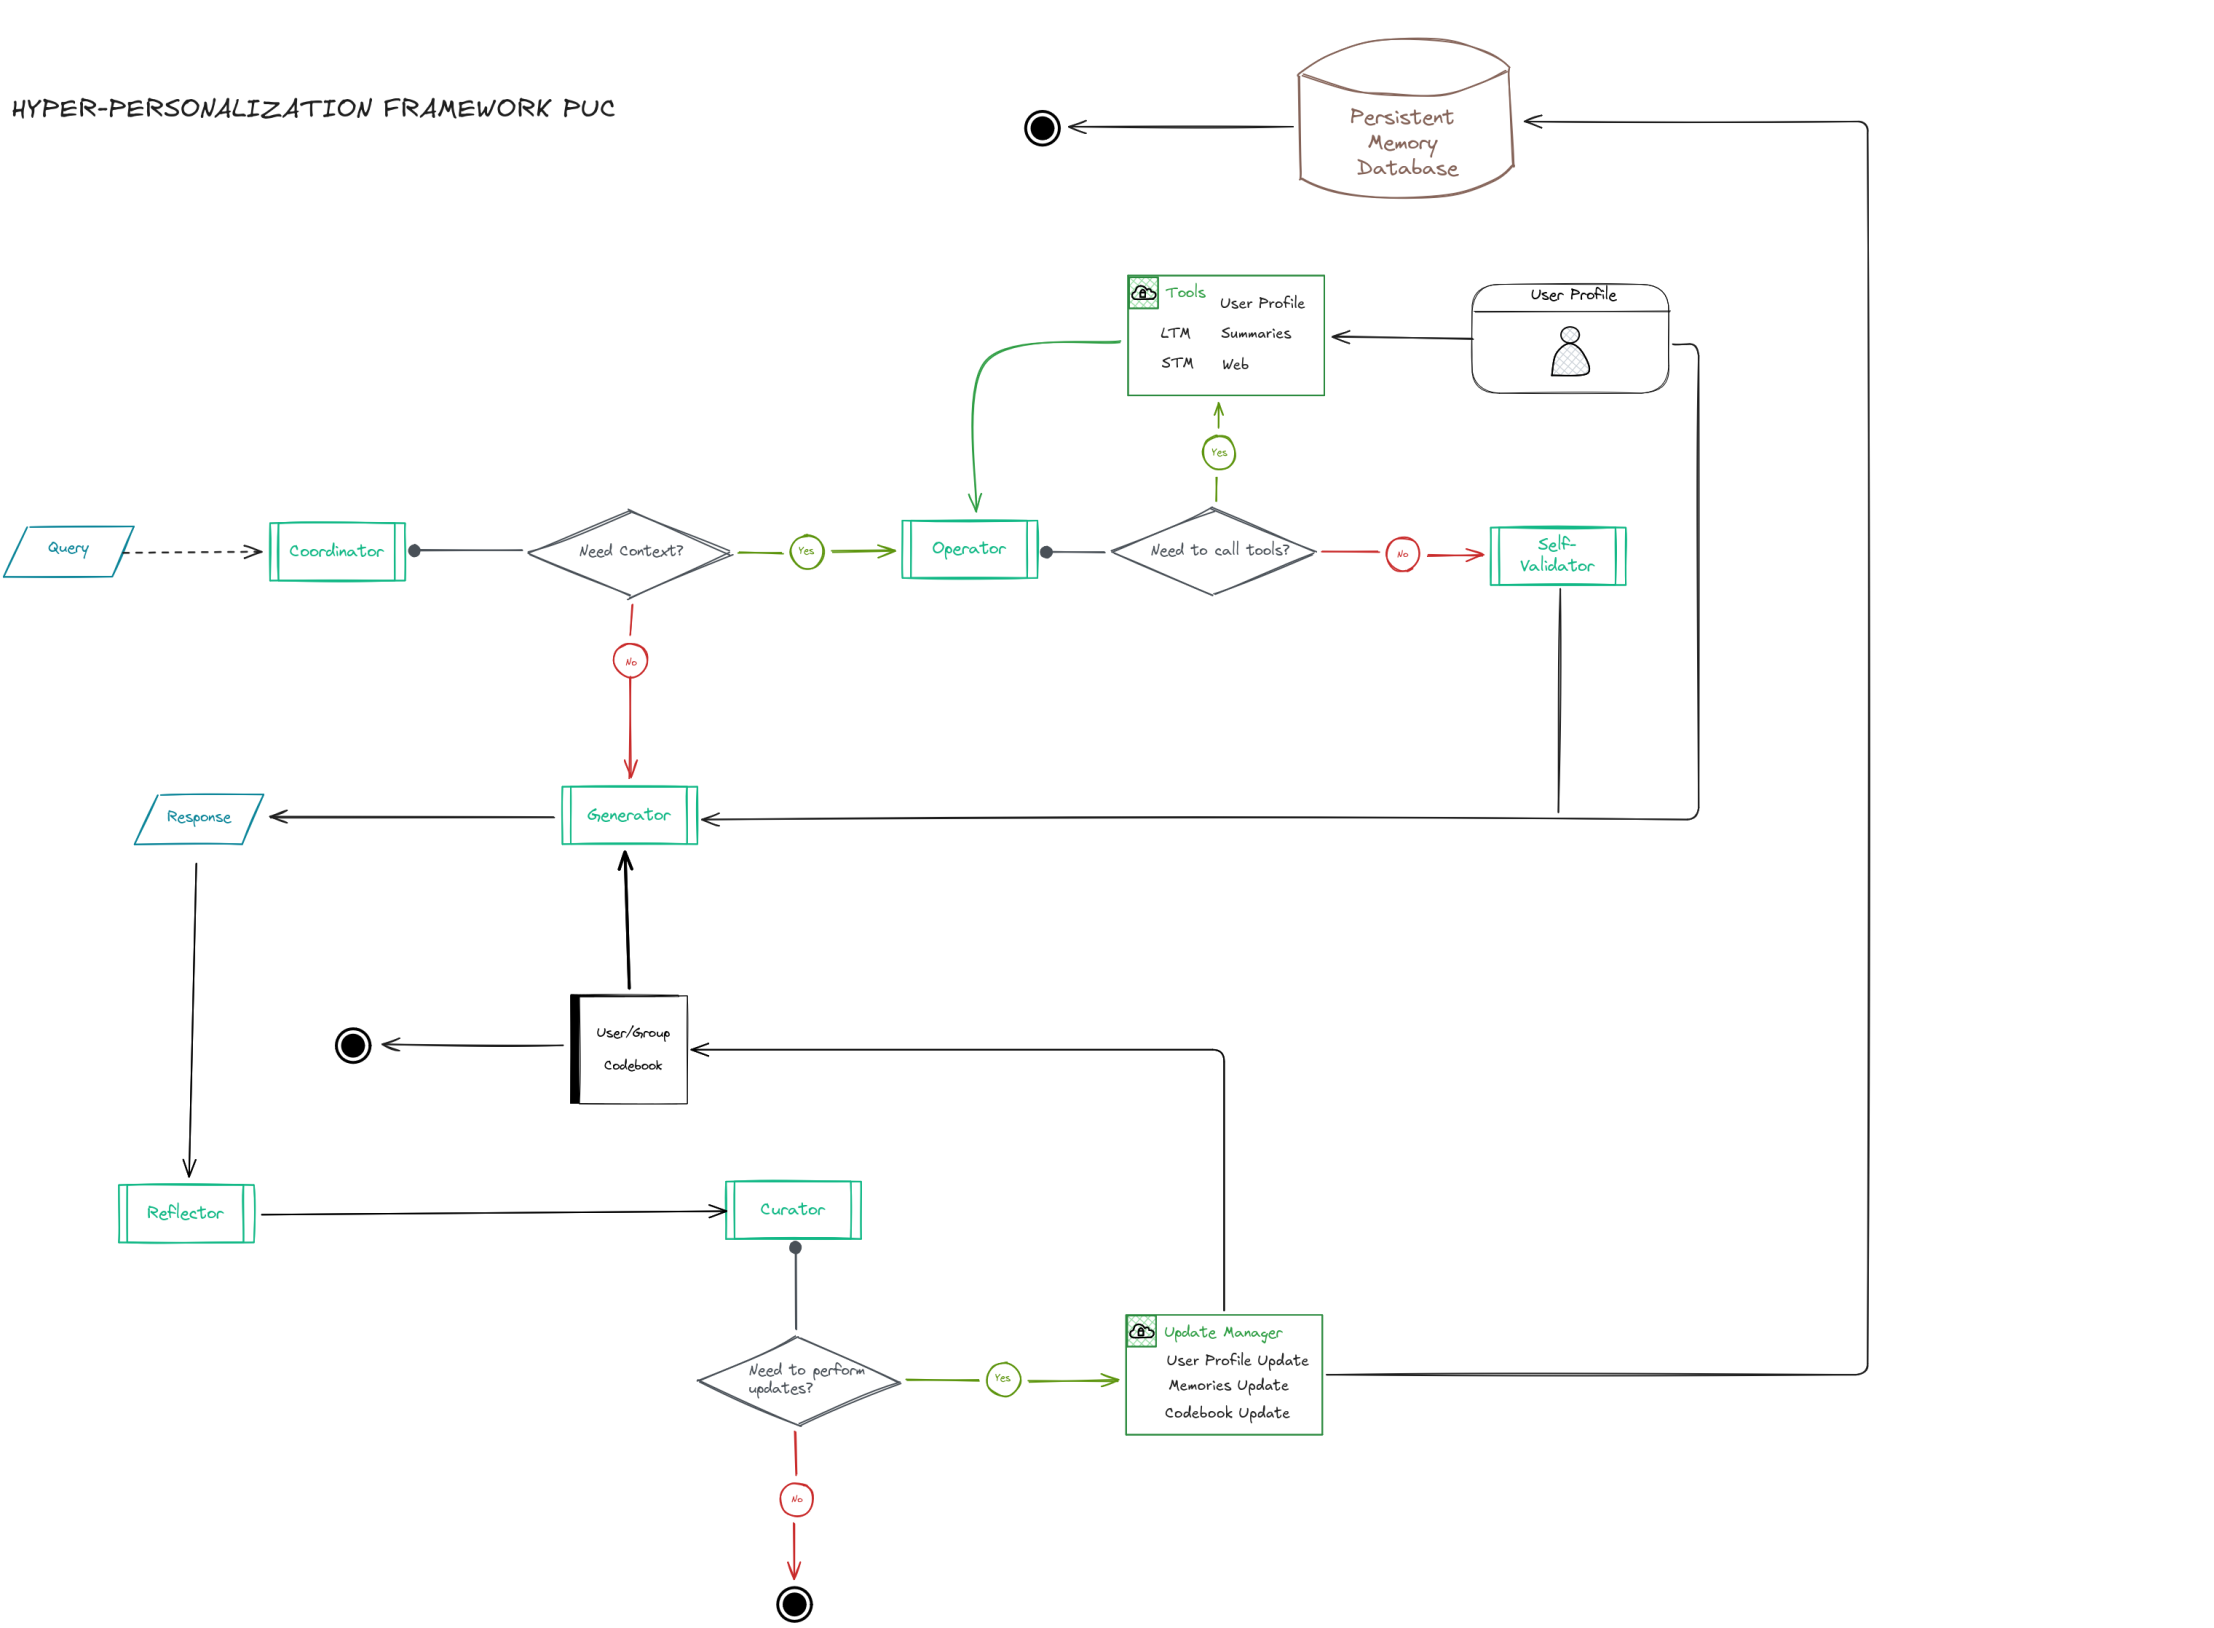

In [ ]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = ""

## Conversations Dataset

In [2]:
import json
locomo10_path = "data/locomo/locomo10.json"
with open(locomo10_path, "r") as f:
    locomo10 = json.load(f)

In [3]:
len(locomo10),len(locomo10[0])

(10, 6)

In [4]:
locomo10[0].keys()

dict_keys(['qa', 'conversation', 'event_summary', 'observation', 'session_summary', 'sample_id'])

In [5]:
locomo10[0]['conversation'].keys()

dict_keys(['speaker_a', 'speaker_b', 'session_1_date_time', 'session_1', 'session_2_date_time', 'session_2', 'session_3_date_time', 'session_3', 'session_4_date_time', 'session_4', 'session_5_date_time', 'session_5', 'session_6_date_time', 'session_6', 'session_7_date_time', 'session_7', 'session_8_date_time', 'session_8', 'session_9_date_time', 'session_9', 'session_10_date_time', 'session_10', 'session_11_date_time', 'session_11', 'session_12_date_time', 'session_12', 'session_13_date_time', 'session_13', 'session_14_date_time', 'session_14', 'session_15_date_time', 'session_15', 'session_16_date_time', 'session_16', 'session_17_date_time', 'session_17', 'session_18_date_time', 'session_18', 'session_19_date_time', 'session_19', 'session_20_date_time', 'session_21_date_time', 'session_22_date_time', 'session_23_date_time', 'session_24_date_time', 'session_25_date_time', 'session_26_date_time', 'session_27_date_time', 'session_28_date_time', 'session_29_date_time', 'session_30_date_ti

In [6]:
locomo10[0]['conversation']

{'speaker_a': 'Caroline',
 'speaker_b': 'Melanie',
 'session_1_date_time': '1:56 pm on 8 May, 2023',
 'session_1': [{'speaker': 'Caroline',
   'dia_id': 'D1:1',
   'text': 'Hey Mel! Good to see you! How have you been?'},
  {'speaker': 'Melanie',
   'dia_id': 'D1:2',
   'text': "Hey Caroline! Good to see you! I'm swamped with the kids & work. What's up with you? Anything new?"},
  {'speaker': 'Caroline',
   'dia_id': 'D1:3',
   'text': 'I went to a LGBTQ support group yesterday and it was so powerful.'},
  {'speaker': 'Melanie',
   'dia_id': 'D1:4',
   'text': "Wow, that's cool, Caroline! What happened that was so awesome? Did you hear any inspiring stories?"},
  {'speaker': 'Caroline',
   'img_url': ['https://i.redd.it/l7hozpetnhlb1.jpg'],
   'blip_caption': 'a photo of a dog walking past a wall with a painting of a woman',
   'query': 'transgender pride flag mural',
   'dia_id': 'D1:5',
   'text': 'The transgender stories were so inspiring! I was so happy and thankful for all the supp

In [7]:
def get_conversation_text(conversation):
    text = ""
    for key in conversation:
        if key.startswith("session_") and not key.endswith("_time"):
            # print(f"Processing {key}")
            session = conversation[key]
            for msg_dict in session:
                # print(msg_dict)
                role = msg_dict['text']
                text += role + "\n"
    return text

def get_conversation_messages(conversation):
    """Extract messages as a list for BM25 and chunking strategies"""
    messages = []
    for key in sorted(conversation.keys()):
        if key.startswith("session_") and not key.endswith("_time"):
            session = conversation[key]
            for msg_dict in session:
                messages.append(msg_dict['text'])
    return messages
    
conversation = get_conversation_text(locomo10[0]['conversation'])
print(len(conversation))

58109


In [8]:
print(conversation[:100])

Hey Mel! Good to see you! How have you been?
Hey Caroline! Good to see you! I'm swamped with the kid


In [9]:
locomo10[0]['qa']

[{'question': 'When did Caroline go to the LGBTQ support group?',
  'answer': '7 May 2023',
  'evidence': ['D1:3'],
  'category': 2},
 {'question': 'When did Melanie paint a sunrise?',
  'answer': 2022,
  'evidence': ['D1:12'],
  'category': 2},
 {'question': 'What fields would Caroline be likely to pursue in her educaton?',
  'answer': 'Psychology, counseling certification',
  'evidence': ['D1:9', 'D1:11'],
  'category': 3},
 {'question': 'What did Caroline research?',
  'answer': 'Adoption agencies',
  'evidence': ['D2:8'],
  'category': 1},
 {'question': "What is Caroline's identity?",
  'answer': 'Transgender woman',
  'evidence': ['D1:5'],
  'category': 1},
 {'question': 'When did Melanie run a charity race?',
  'answer': 'The sunday before 25 May 2023',
  'evidence': ['D2:1'],
  'category': 2},
 {'question': 'When is Melanie planning on going camping?',
  'answer': 'June 2023',
  'evidence': ['D2:7'],
  'category': 2},
 {'question': "What is Caroline's relationship status?",
  'a

In [10]:
queries = locomo10[0]['qa']
print(len(queries))

199


In [11]:
queries[0]['question'], queries[0]['answer']

('When did Caroline go to the LGBTQ support group?', '7 May 2023')

## Playbook 

In [12]:
import uuid
from dataclasses import dataclass, field
from typing import List, Dict, Any
from rank_bm25 import BM25Okapi
import numpy as np

@dataclass
class Bullet:
    """Representa um bullet no playbook com metadata"""
    id: str = field(default_factory=lambda: str(uuid.uuid4()))
    content: str = ""
    helpful_count: int = 0
    harmful_count: int = 0
    
    def mark_helpful(self):
        self.helpful_count += 1
    
    def mark_harmful(self):
        self.harmful_count += 1
    
    def to_dict(self):
        return {
            'id': self.id,
            'content': self.content,
            'helpful_count': self.helpful_count,
            'harmful_count': self.harmful_count
        }
    
    def __str__(self):
        return f"[ID: {self.id[:8]}] {self.content} (✓{self.helpful_count}/✗{self.harmful_count})"

class Playbook:
    """Gerencia a coleção de bullets"""
    def __init__(self):
        self.bullets: List[Bullet] = []
        self.user_profiles: Dict[str, Any] = {}
        self.memories_events: List[Dict[str, Any]] = []
    
    def add_bullet(self, bullet: Bullet):
        self.bullets.append(bullet)
    
    def update_bullet(self, index: int, new_content: str):
        """Update an existing bullet's content"""
        if 0 <= index < len(self.bullets):
            self.bullets[index].content = new_content
            return True
        return False
    
    def remove_bullet(self, index: int):
        """Remove a bullet by index"""
        if 0 <= index < len(self.bullets):
            self.bullets.pop(index)
            return True
        return False
    
    def get_bullet_by_id(self, bullet_id: str) -> Bullet:
        for bullet in self.bullets:
            if bullet.id == bullet_id:
                return bullet
        return None
    
    def get_bullet_by_index(self, index: int) -> Bullet:
        if 0 <= index < len(self.bullets):
            return self.bullets[index]
        return None
    
    #User profile methods
    def add_user_profile(self, user_id: str, profile_data: Dict[str, Any]):
        self.user_profiles[user_id] = profile_data
    
    def get_user_profile(self, user_id: str) -> Dict[str, Any]:
        return self.user_profiles.get(user_id, {})

    def modify_user_profile(self, user_id: str, profile_data: Dict[str, Any]):
        if user_id in self.user_profiles:
            self.user_profiles[user_id].update(profile_data)
        else:
            self.user_profiles[user_id] = profile_data
    
    def remove_user_profile_item(self, user_id: str, key: str):
        """Remove a specific item from user profile"""
        if user_id in self.user_profiles and key in self.user_profiles[user_id]:
            del self.user_profiles[user_id][key]
            return True
        return False

    #Memories and events methods
    def add_memory_event(self, event_data: Dict[str, Any]):
        self.memories_events.append(event_data)
    
    def update_memory_event(self, index: int, new_event_data: Dict[str, Any]):
        """Update an existing memory/event"""
        if 0 <= index < len(self.memories_events):
            self.memories_events[index] = new_event_data
            return True
        return False
    
    def remove_memory_event(self, index: int):
        """Remove a memory/event by index"""
        if 0 <= index < len(self.memories_events):
            self.memories_events.pop(index)
            return True
        return False

    def get_memory_events(self) -> List[Dict[str, Any]]:
        return self.memories_events

    # Formatting for prompt    
    def format_for_prompt(self) -> str:
        if not self.bullets and not self.user_profiles and not self.memories_events:
            # return "Nenhum conhecimento prévio disponível."
            return "No previous knowledge available"
        
        formatted_output = []
        
        # Format bullets with index numbers
        if self.bullets:
            formatted_output.append("Knowledge Bullets:")
            for i, bullet in enumerate(self.bullets):
                formatted_output.append(f"{i}. {bullet}")
        
        # Format user profiles
        if self.user_profiles:
            formatted_output.append("\nUser Profiles:")
            for user_id, profile in self.user_profiles.items():
                formatted_output.append(f"User {user_id}: {profile}")
        
        # Format memories/events with index numbers
        if self.memories_events:
            formatted_output.append("\nMemories and Events:")
            for i, event in enumerate(self.memories_events):
                formatted_output.append(f"{i}. {event}")
        
        return "\n".join(formatted_output)
    
    def __len__(self):
        return len(self.bullets)

In [13]:
# pip install rank_bm25 langchain langchain-ollama langchain-core sentence-transformers faiss-cpu numpy

## Retrieval Engine

In [14]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from typing import List, Tuple

class ConversationRetriever:
    """Retrieval engine for finding relevant conversation chunks"""
    
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', chunk_size: int = 500):
        """
        Initialize the retriever with embedding model and chunk size
        
        Args:
            model_name: Name of the sentence transformer model
            chunk_size: Number of characters per chunk
        """
        self.model = SentenceTransformer(model_name)
        self.chunk_size = chunk_size
        self.chunks: List[str] = []
        self.embeddings: np.ndarray = None
        self.index = None
        
    def chunk_conversation(self, conversation_text: str, overlap: int = 50) -> List[str]:
        """
        Split conversation into overlapping chunks
        
        Args:
            conversation_text: Full conversation text
            overlap: Number of characters to overlap between chunks
            
        Returns:
            List of conversation chunks
        """
        chunks = []
        start = 0
        text_len = len(conversation_text)
        
        while start < text_len:
            end = min(start + self.chunk_size, text_len)
            chunk = conversation_text[start:end]
            
            # Try to break at sentence boundaries
            if end < text_len:
                last_period = chunk.rfind('.')
                last_newline = chunk.rfind('\n')
                break_point = max(last_period, last_newline)
                
                if break_point > self.chunk_size * 0.5:  # Only break if not too early
                    chunk = chunk[:break_point + 1]
                    end = start + break_point + 1
            
            chunks.append(chunk.strip())
            start = end - overlap if end < text_len else end
            
        return chunks
    
    def embed_conversation(self, conversation_text: str):
        """
        Chunk and embed the conversation, build FAISS index
        
        Args:
            conversation_text: Full conversation text to process
        """
        print(f"Chunking conversation with chunk_size={self.chunk_size}...")
        self.chunks = self.chunk_conversation(conversation_text)
        print(f"Created {len(self.chunks)} chunks")
        
        print("Embedding chunks...")
        self.embeddings = self.model.encode(self.chunks, show_progress_bar=True)
        
        print("Building FAISS index...")
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(self.embeddings.astype('float32'))
        
        print(f"✓ Retrieval engine ready with {len(self.chunks)} chunks")
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Tuple[str, float]]:
        """
        Retrieve most relevant conversation chunks for a query
        
        Args:
            query: Query text
            top_k: Number of top chunks to retrieve
            
        Returns:
            List of (chunk_text, distance_score) tuples
        """
        if self.index is None:
            raise ValueError("No conversation embedded. Call embed_conversation() first.")
        
        # Embed the query
        query_embedding = self.model.encode([query])
        
        # Search in FAISS index
        distances, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        # Return chunks with their scores
        results = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx < len(self.chunks):
                results.append((self.chunks[idx], float(dist)))
        
        return results
    
    def get_context(self, query: str, top_k: int = 3, separator: str = "\n\n---\n\n") -> str:
        """
        Get formatted context string from retrieved chunks
        
        Args:
            query: Query text
            top_k: Number of top chunks to retrieve
            separator: Separator between chunks
            
        Returns:
            Formatted context string
        """
        results = self.retrieve(query, top_k)
        chunks = [chunk for chunk, score in results]
        return separator.join(chunks)

# Global retriever instance
retriever = None

/home/spike/miniforge3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def initialize_retriever(conversation_text: str, chunk_size: int = 500, model_name: str = 'all-MiniLM-L6-v2'):
    """
    Initialize the global retriever with conversation data
    
    Args:
        conversation_text: Full conversation text
        chunk_size: Size of each chunk in characters
        model_name: Sentence transformer model name
    """
    global retriever
    retriever = ConversationRetriever(model_name=model_name, chunk_size=chunk_size)
    retriever.embed_conversation(conversation_text)
    return retriever

def get_conversations(question: str, top_k: int = 3) -> str:
    """
    Get relevant conversation context for a question
    
    Args:
        question: The question to find relevant context for
        top_k: Number of relevant chunks to retrieve
        
    Returns:
        Formatted context string with relevant conversation chunks
    """
    global retriever
    if retriever is None:
        raise ValueError("Retriever not initialized. Call initialize_retriever() first.")
    
    return retriever.get_context(question, top_k=top_k)

In [16]:
# Initialize the retriever with the conversation
# You can adjust chunk_size based on your needs:
# - Smaller chunks (200-300): More precise retrieval but may miss context
# - Larger chunks (500-1000): Better context but less precise
retriever = initialize_retriever(conversation, chunk_size=500)

Chunking conversation with chunk_size=500...
Created 141 chunks
Embedding chunks...


Batches: 100%|██████████| 5/5 [00:00<00:00, 33.21it/s]

Building FAISS index...
✓ Retrieval engine ready with 141 chunks


In [17]:
# Test the retriever
test_question = queries[0]['question']
print(f"Question: {test_question}\n")
print("="*80)
print("Retrieved Context:")
print("="*80)
retrieved_context = get_conversations(test_question, top_k=3)
print(retrieved_context)
print("="*80)
print(f"\nContext length: {len(retrieved_context)} characters")

Question: When did Caroline go to the LGBTQ support group?

Retrieved Context:
s to fight for trans rights and spread awareness.
Wow, Caroline, that sounds awesome! So glad you felt accepted and supported. Events like these are great for reminding us of how strong community can be!
Yeah, it's true! Having people who back you makes such a huge difference. It's great to see how far LGBTQ rights have come, but there's still plenty of progress to be made. I wanna help make a difference.
Wow, Caroline. We've come so far, but there's more to do.

---

just joined a new LGBTQ activist group last Tues. I'm meeting so many cool people who are as passionate as I am about rights and community support. I'm giving my voice and making a real difference, plus it's fulfilling in so many ways. It's just great, you know?
That's awesome, Caroline! Glad to hear you found a great group where you can have an impact. Bet it feels great to be able to speak your truth and stand up for what's right. Want to tel

## Sistema

In [18]:
from langchain.tools import tool
from langchain_ollama import ChatOllama

generator = ChatOllama(
    # model="gemma3:12b-it-qat",
    model="gemma3:27b-it-qat",
    temperature=0.1,
)
# reflector = ChatOllama(
#     model="functiongemma",
#     temperature=0.1,
# )
reflector = generator

# curator = ChatOllama(
#     model="functiongemma",
#     temperature=0.1,
# )
curator = generator

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


generator_prompt = """
I am your supervisor and you are a super intelligent AI Assistant whose job is to achieve my day-to-day tasks completely autonomously.
You will be given a cheatsheet containing relevant strategies, patterns, and examples from similar problems to apply and solve the
current task.
Cheatsheet:
{playbook_text}

Context of the Conversation:
{context}

Instructions:
1. ANALYSIS & STRATEGY
Carefully analyze both the question and cheatsheet before starting
Search for and identify any applicable patterns, strategies, or examples within the cheatsheet
Create a structured approach to solving the problem at hand
Review and document any limitations in the provided reference materials
2. SOLUTION DEVELOPMENT
Present your solution using clear, logical steps that others can follow and review
Explain your reasoning and methodology before presenting final conclusions
Provide detailed explanations for each step of the process
Check and verify all assumptions and intermediate calculations


Answer: [your answer here]
Reasoning: [your detailed reasoning here]
Key Insights: [list of key insights derived from the cheatsheet and context]

"""

generator_template = ChatPromptTemplate(
        [
            ("system", generator_prompt),
            ("user", "{query}"),
        ]
    )

generator_chain = (
    generator_template | generator | StrOutputParser()
).with_config({"run_name": "Generator"})

In [20]:
playbook = Playbook()
playbook.format_for_prompt()

'No previous knowledge available'

In [51]:
# question = queries[0]['question']
# question = queries[1]['question']
question = queries[2]['question']
question

'What fields would Caroline be likely to pursue in her educaton?'

## Step by Step

In [52]:
conversations = get_conversations(test_question, top_k=10)
print(conversations)

s to fight for trans rights and spread awareness.
Wow, Caroline, that sounds awesome! So glad you felt accepted and supported. Events like these are great for reminding us of how strong community can be!
Yeah, it's true! Having people who back you makes such a huge difference. It's great to see how far LGBTQ rights have come, but there's still plenty of progress to be made. I wanna help make a difference.
Wow, Caroline. We've come so far, but there's more to do.

---

just joined a new LGBTQ activist group last Tues. I'm meeting so many cool people who are as passionate as I am about rights and community support. I'm giving my voice and making a real difference, plus it's fulfilling in so many ways. It's just great, you know?
That's awesome, Caroline! Glad to hear you found a great group where you can have an impact. Bet it feels great to be able to speak your truth and stand up for what's right. Want to tell me a bit more about it?

---

important it is to keep standing up for equalit

In [53]:
generator_answer = generator_chain.invoke({
    "playbook_text": playbook.format_for_prompt(),
    # "context": conversation[:2000],
    "context": conversations,
    "query": question,
})

In [54]:
generator_answer = "Question:"+question+"\n\n"+generator_answer

In [55]:
print("Generator Answer:\n", generator_answer)

Generator Answer:
 Question:What fields would Caroline be likely to pursue in her educaton?

## ANALYSIS & STRATEGY

This task requires inferring Caroline's potential educational pursuits based on her expressed interests and activities. The cheatsheet highlights the importance of identifying implicit information (ID: 2f275162) and user profiles.  We need to analyze Caroline's statements and the provided memories to deduce fields that align with her passions.  Specifically, we should focus on her advocacy work, her interest in counseling and mental health, and her desire to "give back."  Sequential dialogue analysis (ID: fea24967) will be useful to track the evolution of her interests.  The user profile provides valuable clues about her personality and values.

**Limitations:** The provided information is limited to conversational snippets. We don't have direct statements about her educational background or preferences. Therefore, our answer will be based on inference and educated guess

In [56]:
reflector_prompt = """ You are an expert in extracting insights from conversation interactions.
Context of the Conversation:
{context}
Generated Answer: {generated_answer}
Current Playbook:
{playbook_text}
Analyze the generated answer and reasoning process and identify from a global perspective:
1. Strategies that worked well in generating the answer
2. Important domain concepts that were helpful
3. Patterns in the context that aided in answering
4. Knowledge that would be useful for similar future questions
Also, identify the user profile information:
1. Relevant user preferences or traits revealed in the conversation
2. Behavioral patterns that could inform future interactions
3. Any specific needs or goals indicated by the user
Finally, extract any memories or events from the conversation that could be relevant to improving the playbook

Write the 3 sections in the following format:
INSIGHTS:
1. [insight 1]
2. [insight 2]
...

USER_PROFILE:
1. [profile item 1]
2. [profile item 2]
...

MEMORIES_EVENTS:
1. [memory/event 1]
2. [memory/event 2]
...

"""

reflector_template = ChatPromptTemplate(
        [
            ("system", reflector_prompt),
            ("user", "{query}"),
        ]
    )

In [57]:
reflector_chain = reflector_template | reflector | StrOutputParser()
reflector_chain = reflector_chain.with_config({"run_name": "Reflector"})
reflector_answer = reflector_chain.invoke({
    "playbook_text": playbook.format_for_prompt(),
    "context": conversations,
    "generated_answer": generator_answer,
    "query": "Extract useful insights to improve the playbook.",
})

In [58]:
print("Reflector Answer:\n", reflector_answer)

Reflector Answer:
 INSIGHTS:
1. **Explicit Statement Prioritization:** The playbook correctly prioritized Caroline’s explicit mention of counseling and mental health when inferring potential educational paths. This demonstrates the effectiveness of focusing on direct statements over broader interests.
2. **Interest Mapping to Fields:** The ability to map Caroline’s interests (advocacy, community support, mental health) to relevant fields of study (Social Work, Psychology, Counseling) is a strong analytical capability.
3. **Sequential Analysis for Evolving Interests:** Tracking the evolution of Caroline’s interests – from joining a support group to wanting to “give back” through counseling – helped refine the answer and provide a more nuanced understanding of her goals.
4. **User Profile Integration:** The playbook effectively used the user profile to reinforce the identified interests and values, strengthening the reasoning process.
5. **Avoiding Hallucination:** The playbook correctly

In [59]:
print(playbook.format_for_prompt())

Knowledge Bullets:
0. [ID: 51def37b] **Contextual Resolution of Relative Dates:** The playbook successfully identified the need to resolve relative time references ("yesterday") by looking at surrounding conversational turns. This is a crucial skill for understanding natural language. (✓0/✗0)
1. [ID: fea24967] **Sequential Dialogue Analysis:** The playbook demonstrated the ability to analyze the sequence of dialogue turns to establish a timeline and infer the actual date of the event. This highlights the importance of considering the conversational flow. (✓0/✗0)
2. [ID: 2f275162] **Identifying Implicit Information:** The playbook correctly inferred that the conversation was happening shortly after the support group visit, even though it wasn't explicitly stated. (✓0/✗0)
3. [ID: 2ea0284e] **Importance of Adjacent Turns:** The most useful information for resolving ambiguity (like "yesterday") was found in the immediately preceding and following turns of the conversation. (✓0/✗0)
4. [ID: 

In [60]:
# Curator 1: Insights Curator
insights_curator_prompt = """You are an insights knowledge curator. Your task is to evaluate insights and decide what to add, update, or remove from the playbook's knowledge bullets.

Current Playbook Bullets:
{playbook_bullets}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed Insights:
{insights_text}

Evaluate each insight carefully and decide:
1. Whether the insight should be ADDED as a new bullet (is it useful, relevant, and non-redundant)
2. Whether the insight should UPDATE an existing bullet (if it refines or corrects existing knowledge)
3. Whether existing bullets should be REMOVED (if they are outdated or incorrect)

IMPORTANT: Avoid redundancy! If a new insight is similar to an existing bullet, prefer to UPDATE the existing one rather than adding a duplicate.

Answer in the format:
ADD_INSIGHTS: [list the numbers of insights to add as new bullets, separated by commas, or 'none']
UPDATE_INSIGHTS: [format: "insight_number->bullet_index" to update existing bullet, separated by commas, or 'none']
REMOVE_BULLETS: [list the bullet indices to remove, separated by commas, or 'none']
REASON: [brief explanation of your decisions, especially for updates and removals]

Example:
ADD_INSIGHTS: 1, 3
UPDATE_INSIGHTS: 2->0
REMOVE_BULLETS: none
REASON: Insight 2 refines existing bullet 0 with more specific information. Insights 1 and 3 are novel additions.
"""

insights_curator_template = ChatPromptTemplate(
    [
        ("system", insights_curator_prompt),
        ("user", "{query}"),
    ]
)

insights_curator_chain = insights_curator_template | curator | StrOutputParser()
insights_curator_chain = insights_curator_chain.with_config({"run_name": "Insights Curator"})

# Curator 2: User Profile Curator
user_profile_curator_prompt = """You are a user profile curator. Your task is to evaluate user profile information and decide what to add or update in the playbook.

Current User Profiles:
{user_profiles}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed User Profile Items:
{user_profile_text}

Evaluate each user profile item carefully and decide:
1. Whether the item should be ADDED as new user profile information
2. Whether the item should UPDATE existing user profile information

Answer in the format:
ADD_USER_PROFILE: [list the numbers of user profile items to add, separated by commas, or 'none']
UPDATE_USER_PROFILE: [list the numbers of user profile items to update, separated by commas, or 'none']
REASON: [brief explanation of your decisions]

Example:
ADD_USER_PROFILE: 1, 2
UPDATE_USER_PROFILE: none
REASON: Items 1 and 2 provide new information about user preferences not yet captured.
"""

user_profile_curator_template = ChatPromptTemplate(
    [
        ("system", user_profile_curator_prompt),
        ("user", "{query}"),
    ]
)

user_profile_curator_chain = user_profile_curator_template | curator | StrOutputParser()
user_profile_curator_chain = user_profile_curator_chain.with_config({"run_name": "User Profile Curator"})

# Curator 3: Memories/Events Curator
memories_curator_prompt = """You are a memories and events curator. Your task is to evaluate memories and events extracted from conversations and decide what to add or update in the playbook.

Current Memories and Events:
{memories_events}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed Memories/Events:
{memories_events_text}

Evaluate each memory/event carefully and decide:
1. Whether the memory/event should be ADDED as new information
2. Whether the memory/event should UPDATE existing memory/event information

Answer in the format:
ADD_MEMORIES_EVENTS: [list the numbers of memories/events to add, separated by commas, or 'none']
UPDATE_MEMORIES_EVENTS: [format: "memory_number->event_index" to update existing event, separated by commas, or 'none']
REASON: [brief explanation of your decisions]

Example:
ADD_MEMORIES_EVENTS: 1, 3
UPDATE_MEMORIES_EVENTS: 2->0
REASON: Memory 2 updates event 0 with new information. Memories 1 and 3 are new events.
"""

memories_curator_template = ChatPromptTemplate(
    [
        ("system", memories_curator_prompt),
        ("user", "{query}"),
    ]
)

memories_curator_chain = memories_curator_template | curator | StrOutputParser()
memories_curator_chain = memories_curator_chain.with_config({"run_name": "Memories Curator"})

In [61]:
import re
# Parse reflector answer into sections first
sections = {"INSIGHTS": [], "USER_PROFILE": [], "MEMORIES_EVENTS": []}
current_section = None

for line in reflector_answer.splitlines():
    line_stripped = line.strip()
    line_upper = line_stripped.upper()
    
    # Check for section headers
    if "INSIGHT" in line_upper and ":" in line_stripped:
        current_section = "INSIGHTS"
        continue
    elif "USER" in line_upper and "PROFILE" in line_upper and ":" in line_stripped:
        current_section = "USER_PROFILE"
        continue
    elif "MEMOR" in line_upper and "EVENT" in line_upper and ":" in line_stripped:
        current_section = "MEMORIES_EVENTS"
        continue
    
    # Add content to current section
    if line_stripped and current_section:
        clean_line = re.sub(r'^[\d\-\*]+[\.\)]\s*', '', line_stripped).strip()
        if clean_line and not clean_line.endswith(':'):
            sections[current_section].append(clean_line)

# Format sections for curator prompts
def format_section_list(items, section_name):
    if not items:
        return f"No {section_name} available."
    return "\n".join([f"{i+1}. {item}" for i, item in enumerate(items)])

# Invoke the 3 curators in parallel
print("Running specialized curators...")

# Run insights curator
insights_curator_answer = insights_curator_chain.invoke({
    "playbook_bullets": "\n".join([f"{i}. {bullet}" for i, bullet in enumerate(playbook.bullets)]) if playbook.bullets else "No bullets yet.",
    "query": question,
    "generated_answer": generator_answer,
    "insights_text": format_section_list(sections["INSIGHTS"], "insights"),
})

# Run user profile curator
user_profile_curator_answer = user_profile_curator_chain.invoke({
    "user_profiles": str(playbook.user_profiles) if playbook.user_profiles else "No user profiles yet.",
    "query": question,
    "generated_answer": generator_answer,
    "user_profile_text": format_section_list(sections["USER_PROFILE"], "user profile items"),
})

# Run memories curator
memories_curator_answer = memories_curator_chain.invoke({
    "memories_events": "\n".join([f"{i}. {event}" for i, event in enumerate(playbook.memories_events)]) if playbook.memories_events else "No memories/events yet.",
    "query": question,
    "generated_answer": generator_answer,
    "memories_events_text": format_section_list(sections["MEMORIES_EVENTS"], "memories/events"),
})

# Combine all curator answers
curator_answer = f"{insights_curator_answer}\n{user_profile_curator_answer}\n{memories_curator_answer}"

print("✓ All curators completed")

Running specialized curators...
✓ All curators completed


In [62]:
print("Curator Answer:\n", curator_answer)

Curator Answer:
 ADD_INSIGHTS: 1, 2, 3
UPDATE_INSIGHTS: none
REMOVE_BULLETS: none
REASON: The three proposed insights represent distinct and valuable learnings from this interaction. Insight 1 highlights the importance of prioritizing explicit statements, which wasn't previously captured. Insight 2 demonstrates the playbook's ability to connect interests to potential fields, and Insight 3 shows the benefit of sequential analysis. None of these overlap significantly with existing bullets, making them suitable additions to the playbook.

ADD_USER_PROFILE: 3, 4, 5, 6, 7, 8
UPDATE_USER_PROFILE: none
REASON: The proposed user profile items accurately reflect Caroline's personality and values as demonstrated in the conversation. They expand upon the existing profile without contradicting any previously established information. Items 3-8 provide a more nuanced understanding of her motivations and preferences, which will be helpful for future inferences. They also highlight key characteristics

In [63]:
# Debug: Show the exact structure of reflector answer
print("=" * 80)
print("REFLECTOR OUTPUT (for debugging):")
print("=" * 80)
print(reflector_answer)
print("=" * 80)

REFLECTOR OUTPUT (for debugging):
INSIGHTS:
1. **Explicit Statement Prioritization:** The playbook correctly prioritized Caroline’s explicit mention of counseling and mental health when inferring potential educational paths. This demonstrates the effectiveness of focusing on direct statements over broader interests.
2. **Interest Mapping to Fields:** The ability to map Caroline’s interests (advocacy, community support, mental health) to relevant fields of study (Social Work, Psychology, Counseling) is a strong analytical capability.
3. **Sequential Analysis for Evolving Interests:** Tracking the evolution of Caroline’s interests – from joining a support group to wanting to “give back” through counseling – helped refine the answer and provide a more nuanced understanding of her goals.
4. **User Profile Integration:** The playbook effectively used the user profile to reinforce the identified interests and values, strengthening the reasoning process.
5. **Avoiding Hallucination:** The pla

In [64]:
#Parsing the curator answer to update the playbook
import re

# Parse the combined curator answer
insights_to_add = []
insights_to_update = {}  # {insight_idx: bullet_idx}
bullets_to_remove = []
user_profiles_to_add = []
user_profiles_to_update = []
memories_events_to_add = []
memories_events_to_update = {}  # {insight_idx: event_idx}

for line in curator_answer.splitlines():
    line = line.strip()
    
    if line.startswith("ADD_INSIGHTS:"):
        add_part = line[len("ADD_INSIGHTS:"):].strip()
        if add_part.lower() != "none":
            insights_to_add = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
    
    elif line.startswith("UPDATE_INSIGHTS:"):
        update_part = line[len("UPDATE_INSIGHTS:"):].strip()
        if update_part.lower() != "none":
            # Parse format: "1->0, 2->1"
            for item in update_part.split(","):
                if "->" in item:
                    parts = item.split("->")
                    if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                        insights_to_update[int(parts[0].strip())] = int(parts[1].strip())
    
    elif line.startswith("REMOVE_BULLETS:"):
        remove_part = line[len("REMOVE_BULLETS:"):].strip()
        if remove_part.lower() != "none":
            bullets_to_remove = [int(x.strip()) for x in remove_part.split(",") if x.strip().isdigit()]
    
    elif line.startswith("ADD_USER_PROFILE:"):
        add_part = line[len("ADD_USER_PROFILE:"):].strip()
        if add_part.lower() != "none":
            user_profiles_to_add = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
    
    elif line.startswith("UPDATE_USER_PROFILE:"):
        update_part = line[len("UPDATE_USER_PROFILE:"):].strip()
        if update_part.lower() != "none":
            user_profiles_to_update = [int(x.strip()) for x in update_part.split(",") if x.strip().isdigit()]
    
    elif line.startswith("ADD_MEMORIES_EVENTS:"):
        add_part = line[len("ADD_MEMORIES_EVENTS:"):].strip()
        if add_part.lower() != "none":
            memories_events_to_add = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
    
    elif line.startswith("UPDATE_MEMORIES_EVENTS:"):
        update_part = line[len("UPDATE_MEMORIES_EVENTS:"):].strip()
        if update_part.lower() != "none":
            for item in update_part.split(","):
                if "->" in item:
                    parts = item.split("->")
                    if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                        memories_events_to_update[int(parts[0].strip())] = int(parts[1].strip())
    
    elif line.startswith("REASON:"):
        reason_part = line[len("REASON:"):].strip()
        print(f"  Reason: {reason_part}")

print(f"\nActions to perform:")
print(f"  Add Insights: {insights_to_add}")
print(f"  Update Insights: {insights_to_update}")
print(f"  Remove Bullets: {bullets_to_remove}")
print(f"  Add Profiles: {user_profiles_to_add}")
print(f"  Update Profiles: {user_profiles_to_update}")
print(f"  Add Events: {memories_events_to_add}")
print(f"  Update Events: {memories_events_to_update}")

print(f"\nParsed sections - INSIGHTS: {len(sections['INSIGHTS'])}, USER_PROFILE: {len(sections['USER_PROFILE'])}, MEMORIES_EVENTS: {len(sections['MEMORIES_EVENTS'])}")

# 1. Remove bullets (do this first to maintain correct indices)
for idx in sorted(bullets_to_remove, reverse=True):
    if playbook.remove_bullet(idx):
        print(f"🗑️  Removed Bullet at index {idx}")

# 2. Update existing bullets
for insight_idx, bullet_idx in insights_to_update.items():
    if 0 <= insight_idx - 1 < len(sections["INSIGHTS"]):
        insight_content = sections["INSIGHTS"][insight_idx - 1]
        if playbook.update_bullet(bullet_idx, insight_content):
            print(f"🔄 Updated Bullet {bullet_idx}: {insight_content[:60]}...")

# 3. Add new insights as bullets
for idx in insights_to_add:
    if 0 <= idx - 1 < len(sections["INSIGHTS"]):
        insight_content = sections["INSIGHTS"][idx - 1]
        new_bullet = Bullet(content=insight_content)
        playbook.add_bullet(new_bullet)
        print(f"✓ Added Bullet: {insight_content[:60]}...")

# 4. Add user profile information
for idx in user_profiles_to_add:
    if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
        profile_content = sections["USER_PROFILE"][idx - 1]
        user_id = "default_user"
        playbook.modify_user_profile(user_id, {f"item_{idx}": profile_content})
        print(f"✓ Added User Profile: {profile_content[:60]}...")

# 5. Update user profile information
for idx in user_profiles_to_update:
    if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
        profile_content = sections["USER_PROFILE"][idx - 1]
        user_id = "default_user"
        playbook.modify_user_profile(user_id, {f"item_{idx}": profile_content})
        print(f"🔄 Updated User Profile: {profile_content[:60]}...")

# 6. Update memories/events
for insight_idx, event_idx in memories_events_to_update.items():
    if 0 <= insight_idx - 1 < len(sections["MEMORIES_EVENTS"]):
        event_content = sections["MEMORIES_EVENTS"][insight_idx - 1]
        if playbook.update_memory_event(event_idx, {"event": event_content}):
            print(f"🔄 Updated Memory/Event {event_idx}: {event_content[:60]}...")

# 7. Add new memories and events
for idx in memories_events_to_add:
    if 0 <= idx - 1 < len(sections["MEMORIES_EVENTS"]):
        event_content = sections["MEMORIES_EVENTS"][idx - 1]
        playbook.add_memory_event({"event": event_content})
        print(f"✓ Added Memory/Event: {event_content[:60]}...")

print(f"\n{'='*60}")
print(f"Playbook Summary:")
print(f"  Bullets: {len(playbook)}")
print(f"  User Profiles: {len(playbook.user_profiles)}")
print(f"  Memories/Events: {len(playbook.memories_events)}")
print(f"{'='*60}")

  Reason: The three proposed insights represent distinct and valuable learnings from this interaction. Insight 1 highlights the importance of prioritizing explicit statements, which wasn't previously captured. Insight 2 demonstrates the playbook's ability to connect interests to potential fields, and Insight 3 shows the benefit of sequential analysis. None of these overlap significantly with existing bullets, making them suitable additions to the playbook.
  Reason: The proposed user profile items accurately reflect Caroline's personality and values as demonstrated in the conversation. They expand upon the existing profile without contradicting any previously established information. Items 3-8 provide a more nuanced understanding of her motivations and preferences, which will be helpful for future inferences. They also highlight key characteristics that are relevant to identifying potential educational pursuits.
  Reason: The provided memories and events already sufficiently cover Caro

In [65]:
print(playbook.format_for_prompt())

Knowledge Bullets:
0. [ID: 51def37b] **Contextual Resolution of Relative Dates:** The playbook successfully identified the need to resolve relative time references ("yesterday") by looking at surrounding conversational turns. This is a crucial skill for understanding natural language. (✓0/✗0)
1. [ID: fea24967] **Sequential Dialogue Analysis:** The playbook demonstrated the ability to analyze the sequence of dialogue turns to establish a timeline and infer the actual date of the event. This highlights the importance of considering the conversational flow. (✓0/✗0)
2. [ID: 2f275162] **Identifying Implicit Information:** The playbook correctly inferred that the conversation was happening shortly after the support group visit, even though it wasn't explicitly stated. (✓0/✗0)
3. [ID: 2ea0284e] **Importance of Adjacent Turns:** The most useful information for resolving ambiguity (like "yesterday") was found in the immediately preceding and following turns of the conversation. (✓0/✗0)
4. [ID: 

In [66]:
# Knowledge Bullets:
# 0. [ID: 51def37b] **Contextual Resolution of Relative Dates:** The playbook successfully identified the need to resolve relative time references ("yesterday") by looking at surrounding conversational turns. This is a crucial skill for understanding natural language. (✓0/✗0)
# 1. [ID: fea24967] **Sequential Dialogue Analysis:** The playbook demonstrated the ability to analyze the sequence of dialogue turns to establish a timeline and infer the actual date of the event. This highlights the importance of considering the conversational flow. (✓0/✗0)
# 2. [ID: 2f275162] **Identifying Implicit Information:** The playbook correctly inferred that the conversation was happening shortly after the support group visit, even though it wasn't explicitly stated. (✓0/✗0)
# 3. [ID: 2ea0284e] **Importance of Adjacent Turns:** The most useful information for resolving ambiguity (like "yesterday") was found in the immediately preceding and following turns of the conversation. (✓0/✗0)

# User Profiles:
# User default_user: {'item_1': '**Passionate Advocate:** Caroline is actively involved in LGBTQ+ advocacy, having joined a support group and attending events.', 'item_2': '**Story-Sharing Inclination:** Caroline is willing to share her experiences and motivations with others.', 'item_3': '**Positive and Encouraged:** Caroline expresses positive emotions (awesome, inspiring, happy, thankful) about her involvement.', 'item_4': '**Seeking Connection:** Caroline engages in conversation and responds positively to expressions of support.', 'item_6': '**Values Community:** Caroline emphasizes the importance of community support and acceptance.', 'item_5': '**Future-Oriented:** Caroline is thinking about how to further her advocacy efforts (considering counseling and mental health).'}

# Memories and Events:
# 0. {'event': '**Joined LGBTQ Activist Group (Last Tuesday):** Caroline recently joined a new LGBTQ activist group.'}
# 1. {'event': '**Attended LGBTQ Support Group (Wednesday):** Caroline attended a support group meeting and found it powerful and inspiring.'}
# 2. {'event': '**Attended LGBTQ+ Pride Parade:** Caroline participated in a pride parade and felt a sense of belonging.'}
# 3. {'event': "**Mentee's Positive Reaction:** Caroline had a special moment with her mentee at an event."}
# 4. {'event': '**Visited LGBTQ Center & Painted:** Caroline visited an LGBTQ center and created a painting inspired by the experience.'}
# 5. {'event': '**Attended LGBTQ event featuring artists:** Caroline is planning to attend an event featuring LGBTQ artists.'}
# 6. {'event': "**Shared Story at Parade:** Caroline's experience at the parade motivated her to use her story to help others."}
# 7. {'event': "**Connected LGBTQ Activists Group:** Caroline is part of a group called 'Connected LGBTQ Activists' that focuses on positive change."}

## Run all Questions

In [67]:
def generate_answer(question: str, playbook: Playbook, top_k: int = 10) -> str:
    """
    Generate an answer for a question using the current playbook
    
    Args:
        question: The question to answer
        playbook: Current playbook state
        top_k: Number of conversation chunks to retrieve
        
    Returns:
        Generated answer with reasoning
    """
    conversations = get_conversations(question, top_k=top_k)
    
    generator_answer = generator_chain.invoke({
        "playbook_text": playbook.format_for_prompt(),
        "context": conversations,
        "query": question,
    })
    
    return f"Question: {question}\n\n{generator_answer}"

In [68]:
def reflect_on_answer(question: str, generated_answer: str, playbook: Playbook, top_k: int = 10) -> str:
    """
    Reflect on the generated answer and extract insights
    
    Args:
        question: The original question
        generated_answer: The generated answer
        playbook: Current playbook state
        top_k: Number of conversation chunks to retrieve
        
    Returns:
        Reflector output with insights, user profiles, and memories/events
    """
    conversations = get_conversations(question, top_k=top_k)
    
    reflector_answer = reflector_chain.invoke({
        "playbook_text": playbook.format_for_prompt(),
        "context": conversations,
        "generated_answer": generated_answer,
        "query": "Extract useful insights to improve the playbook.",
    })
    
    return reflector_answer

In [69]:
def parse_reflector_sections(reflector_answer: str) -> Dict[str, List[str]]:
    """
    Parse reflector answer into three sections: INSIGHTS, USER_PROFILE, MEMORIES_EVENTS
    
    Args:
        reflector_answer: Raw reflector output
        
    Returns:
        Dictionary with parsed sections
    """
    sections = {"INSIGHTS": [], "USER_PROFILE": [], "MEMORIES_EVENTS": []}
    current_section = None
    
    for line in reflector_answer.splitlines():
        line_stripped = line.strip()
        line_upper = line_stripped.upper()
        
        # Check for section headers
        if "INSIGHT" in line_upper and ":" in line_stripped:
            current_section = "INSIGHTS"
            continue
        elif "USER" in line_upper and "PROFILE" in line_upper and ":" in line_stripped:
            current_section = "USER_PROFILE"
            continue
        elif "MEMOR" in line_upper and "EVENT" in line_upper and ":" in line_stripped:
            current_section = "MEMORIES_EVENTS"
            continue
        
        # Add content to current section
        if line_stripped and current_section:
            clean_line = re.sub(r'^[\d\-\*]+[\.\)]\s*', '', line_stripped).strip()
            if clean_line and not clean_line.endswith(':'):
                sections[current_section].append(clean_line)
    
    return sections

In [70]:
def run_curators(question: str, generated_answer: str, sections: Dict[str, List[str]], playbook: Playbook) -> str:
    """
    Run the three specialized curators and combine their answers
    
    Args:
        question: The original question
        generated_answer: The generated answer
        sections: Parsed reflector sections
        playbook: Current playbook state
        
    Returns:
        Combined curator answers
    """
    def format_section_list(items, section_name):
        if not items:
            return f"No {section_name} available."
        return "\n".join([f"{i+1}. {item}" for i, item in enumerate(items)])
    
    # Run insights curator
    insights_curator_answer = insights_curator_chain.invoke({
        "playbook_bullets": "\n".join([f"{i}. {bullet}" for i, bullet in enumerate(playbook.bullets)]) if playbook.bullets else "No bullets yet.",
        "query": question,
        "generated_answer": generated_answer,
        "insights_text": format_section_list(sections["INSIGHTS"], "insights"),
    })
    
    # Run user profile curator
    user_profile_curator_answer = user_profile_curator_chain.invoke({
        "user_profiles": str(playbook.user_profiles) if playbook.user_profiles else "No user profiles yet.",
        "query": question,
        "generated_answer": generated_answer,
        "user_profile_text": format_section_list(sections["USER_PROFILE"], "user profile items"),
    })
    
    # Run memories curator
    memories_curator_answer = memories_curator_chain.invoke({
        "memories_events": "\n".join([f"{i}. {event}" for i, event in enumerate(playbook.memories_events)]) if playbook.memories_events else "No memories/events yet.",
        "query": question,
        "generated_answer": generated_answer,
        "memories_events_text": format_section_list(sections["MEMORIES_EVENTS"], "memories/events"),
    })
    
    # Combine all curator answers
    return f"{insights_curator_answer}\n{user_profile_curator_answer}\n{memories_curator_answer}"

In [71]:
def parse_curator_actions(curator_answer: str) -> Dict[str, Any]:
    """
    Parse curator answer to extract all actions to perform
    
    Args:
        curator_answer: Combined curator answers
        
    Returns:
        Dictionary with all parsed actions
    """
    actions = {
        'insights_to_add': [],
        'insights_to_update': {},
        'bullets_to_remove': [],
        'user_profiles_to_add': [],
        'user_profiles_to_update': [],
        'memories_events_to_add': [],
        'memories_events_to_update': {}
    }
    
    for line in curator_answer.splitlines():
        line = line.strip()
        
        if line.startswith("ADD_INSIGHTS:"):
            add_part = line[len("ADD_INSIGHTS:"):].strip()
            if add_part.lower() != "none":
                actions['insights_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_INSIGHTS:"):
            update_part = line[len("UPDATE_INSIGHTS:"):].strip()
            if update_part.lower() != "none":
                for item in update_part.split(","):
                    if "->" in item:
                        parts = item.split("->")
                        if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                            actions['insights_to_update'][int(parts[0].strip())] = int(parts[1].strip())
        
        elif line.startswith("REMOVE_BULLETS:"):
            remove_part = line[len("REMOVE_BULLETS:"):].strip()
            if remove_part.lower() != "none":
                actions['bullets_to_remove'] = [int(x.strip()) for x in remove_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("ADD_USER_PROFILE:"):
            add_part = line[len("ADD_USER_PROFILE:"):].strip()
            if add_part.lower() != "none":
                actions['user_profiles_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_USER_PROFILE:"):
            update_part = line[len("UPDATE_USER_PROFILE:"):].strip()
            if update_part.lower() != "none":
                actions['user_profiles_to_update'] = [int(x.strip()) for x in update_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("ADD_MEMORIES_EVENTS:"):
            add_part = line[len("ADD_MEMORIES_EVENTS:"):].strip()
            if add_part.lower() != "none":
                actions['memories_events_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_MEMORIES_EVENTS:"):
            update_part = line[len("UPDATE_MEMORIES_EVENTS:"):].strip()
            if update_part.lower() != "none":
                for item in update_part.split(","):
                    if "->" in item:
                        parts = item.split("->")
                        if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                            actions['memories_events_to_update'][int(parts[0].strip())] = int(parts[1].strip())
    
    return actions

In [72]:
def update_playbook_from_actions(playbook: Playbook, sections: Dict[str, List[str]], actions: Dict[str, Any], verbose: bool = True):
    """
    Update the playbook based on curator actions
    
    Args:
        playbook: Playbook to update
        sections: Parsed reflector sections
        actions: Parsed curator actions
        verbose: Whether to print update information
    """
    # 1. Remove bullets (do this first to maintain correct indices)
    for idx in sorted(actions['bullets_to_remove'], reverse=True):
        if playbook.remove_bullet(idx):
            if verbose:
                print(f"🗑️  Removed Bullet at index {idx}")
    
    # 2. Update existing bullets
    for insight_idx, bullet_idx in actions['insights_to_update'].items():
        if 0 <= insight_idx - 1 < len(sections["INSIGHTS"]):
            insight_content = sections["INSIGHTS"][insight_idx - 1]
            if playbook.update_bullet(bullet_idx, insight_content):
                if verbose:
                    print(f"🔄 Updated Bullet {bullet_idx}: {insight_content[:60]}...")
    
    # 3. Add new insights as bullets
    for idx in actions['insights_to_add']:
        if 0 <= idx - 1 < len(sections["INSIGHTS"]):
            insight_content = sections["INSIGHTS"][idx - 1]
            new_bullet = Bullet(content=insight_content)
            playbook.add_bullet(new_bullet)
            if verbose:
                print(f"✓ Added Bullet: {insight_content[:60]}...")
    
    # 4. Add user profile information
    for idx in actions['user_profiles_to_add']:
        if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
            profile_content = sections["USER_PROFILE"][idx - 1]
            user_id = "default_user"
            playbook.modify_user_profile(user_id, {f"item_{idx}": profile_content})
            if verbose:
                print(f"✓ Added User Profile: {profile_content[:60]}...")
    
    # 5. Update user profile information
    for idx in actions['user_profiles_to_update']:
        if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
            profile_content = sections["USER_PROFILE"][idx - 1]
            user_id = "default_user"
            playbook.modify_user_profile(user_id, {f"item_{idx}": profile_content})
            if verbose:
                print(f"🔄 Updated User Profile: {profile_content[:60]}...")
    
    # 6. Update memories/events
    for insight_idx, event_idx in actions['memories_events_to_update'].items():
        if 0 <= insight_idx - 1 < len(sections["MEMORIES_EVENTS"]):
            event_content = sections["MEMORIES_EVENTS"][insight_idx - 1]
            if playbook.update_memory_event(event_idx, {"event": event_content}):
                if verbose:
                    print(f"🔄 Updated Memory/Event {event_idx}: {event_content[:60]}...")
    
    # 7. Add new memories and events
    for idx in actions['memories_events_to_add']:
        if 0 <= idx - 1 < len(sections["MEMORIES_EVENTS"]):
            event_content = sections["MEMORIES_EVENTS"][idx - 1]
            playbook.add_memory_event({"event": event_content})
            if verbose:
                print(f"✓ Added Memory/Event: {event_content[:60]}...")

In [73]:
def populate_codebook(questions: List[str], initial_playbook: Playbook = None, top_k: int = 10, verbose: bool = True) -> Playbook:
    """
    Main function to populate a codebook/playbook from a list of questions
    
    This function processes each question through the full pipeline:
    1. Generate answer using current playbook
    2. Reflect on the answer to extract insights
    3. Run specialized curators to evaluate insights
    4. Update the playbook with approved changes
    
    Args:
        questions: List of questions to process
        initial_playbook: Starting playbook (creates new one if None)
        top_k: Number of conversation chunks to retrieve for context
        verbose: Whether to print detailed progress information
        
    Returns:
        Populated Playbook object
    """
    # Initialize playbook
    if initial_playbook is None:
        playbook = Playbook()
    else:
        playbook = initial_playbook
    
    print(f"{'='*80}")
    print(f"Starting Playbook Population with {len(questions)} questions")
    print(f"{'='*80}\n")
    
    for i, question in enumerate(questions, 1):
        print(f"\n{'='*80}")
        print(f"Processing Question {i}/{len(questions)}")
        print(f"{'='*80}")
        print(f"Q: {question}\n")
        
        # Step 1: Generate answer
        if verbose:
            print("⏳ Generating answer...")
        generated_answer = generate_answer(question, playbook, top_k=top_k)
        if verbose:
            print(f"✓ Answer generated ({len(generated_answer)} chars)\n")
        
        # Step 2: Reflect on answer
        if verbose:
            print("⏳ Reflecting on answer...")
        reflector_answer = reflect_on_answer(question, generated_answer, playbook, top_k=top_k)
        if verbose:
            print(f"✓ Reflection complete\n")
        
        # Step 3: Parse reflector sections
        sections = parse_reflector_sections(reflector_answer)
        if verbose:
            print(f"📊 Parsed sections:")
            print(f"   - Insights: {len(sections['INSIGHTS'])}")
            print(f"   - User Profiles: {len(sections['USER_PROFILE'])}")
            print(f"   - Memories/Events: {len(sections['MEMORIES_EVENTS'])}\n")
        
        # Step 4: Run curators
        if verbose:
            print("⏳ Running specialized curators...")
        curator_answer = run_curators(question, generated_answer, sections, playbook)
        if verbose:
            print(f"✓ All curators completed\n")
        
        # Step 5: Parse curator actions
        actions = parse_curator_actions(curator_answer)
        if verbose:
            print(f"📝 Curator decisions:")
            print(f"   - Add Insights: {actions['insights_to_add']}")
            print(f"   - Update Insights: {actions['insights_to_update']}")
            print(f"   - Remove Bullets: {actions['bullets_to_remove']}")
            print(f"   - Add Profiles: {actions['user_profiles_to_add']}")
            print(f"   - Update Profiles: {actions['user_profiles_to_update']}")
            print(f"   - Add Events: {actions['memories_events_to_add']}")
            print(f"   - Update Events: {actions['memories_events_to_update']}\n")
        
        # Step 6: Update playbook
        if verbose:
            print("⏳ Updating playbook...")
        update_playbook_from_actions(playbook, sections, actions, verbose=verbose)
        
        # Print summary
        print(f"\n📚 Playbook Status after Question {i}:")
        print(f"   - Bullets: {len(playbook)}")
        print(f"   - User Profiles: {len(playbook.user_profiles)}")
        print(f"   - Memories/Events: {len(playbook.memories_events)}")
    
    print(f"\n{'='*80}")
    print(f"Playbook Population Complete!")
    print(f"{'='*80}")
    print(f"Final Statistics:")
    print(f"   - Total Bullets: {len(playbook)}")
    print(f"   - Total User Profiles: {len(playbook.user_profiles)}")
    print(f"   - Total Memories/Events: {len(playbook.memories_events)}")
    print(f"{'='*80}\n")
    
    return playbook

In [74]:
# Example usage: Process all questions from the dataset
question_list = [q['question'] for q in queries]
print(f"Total questions available: {len(question_list)}")
print("\nFirst 5 questions:")
for i, q in enumerate(question_list[:5], 1):
    print(f"{i}. {q}")

Total questions available: 199

First 5 questions:
1. When did Caroline go to the LGBTQ support group?
2. When did Melanie paint a sunrise?
3. What fields would Caroline be likely to pursue in her educaton?
4. What did Caroline research?
5. What is Caroline's identity?


In [75]:
# Run populate_codebook on a subset of questions (e.g., first 3)
# Uncomment to run:
final_playbook = populate_codebook(question_list[:5], top_k=10, verbose=True)

Starting Playbook Population with 5 questions


Processing Question 1/5
Q: When did Caroline go to the LGBTQ support group?

⏳ Generating answer...
✓ Answer generated (1980 chars)

⏳ Reflecting on answer...
✓ Reflection complete

📊 Parsed sections:
   - Insights: 5
   - User Profiles: 5
   - Memories/Events: 8

⏳ Running specialized curators...
✓ All curators completed

📝 Curator decisions:
   - Add Insights: [1, 2, 3]
   - Update Insights: {}
   - Remove Bullets: []
   - Add Profiles: [1, 2, 3, 4, 5]
   - Update Profiles: []
   - Add Events: [1, 2, 3, 4, 5, 6, 7, 8]
   - Update Events: {}

⏳ Updating playbook...
✓ Added Bullet: **Direct Answer Extraction:** The playbook successfully iden...
✓ Added Bullet: **Dialogue Context Awareness:** While not strictly *necessar...
✓ Added Bullet: **Simple Question Type:** The question was a straightforward...
✓ Added User Profile: **Supportive & Encouraging:** Mel consistently offers positi...
✓ Added User Profile: **Interested in Details:** Mel 

In [ ]:
# Run populate_codebook on ALL questions
# Warning: This may take significant time depending on the number of questions
# Uncomment to run:
# final_playbook = populate_codebook(question_list, top_k=10, verbose=True)

In [77]:
# Display the final playbook
def display_playbook_summary(playbook: Playbook):
    """Display a formatted summary of the playbook contents"""
    print(f"\n{'='*80}")
    print("PLAYBOOK SUMMARY")
    print(f"{'='*80}\n")
    
    # Display bullets
    if playbook.bullets:
        print(f"📌 KNOWLEDGE BULLETS ({len(playbook.bullets)}):")
        print("-" * 80)
        for i, bullet in enumerate(playbook.bullets):
            print(f"{i}. {bullet.content}")
            print(f"   [✓{bullet.helpful_count}/✗{bullet.harmful_count}]")
            print()
    else:
        print("📌 KNOWLEDGE BULLETS: None\n")
    
    # Display user profiles
    if playbook.user_profiles:
        print(f"👤 USER PROFILES ({len(playbook.user_profiles)}):")
        print("-" * 80)
        for user_id, profile in playbook.user_profiles.items():
            print(f"User: {user_id}")
            for key, value in profile.items():
                print(f"  - {key}: {value}")
            print()
    else:
        print("👤 USER PROFILES: None\n")
    
    # Display memories/events
    if playbook.memories_events:
        print(f"🎯 MEMORIES & EVENTS ({len(playbook.memories_events)}):")
        print("-" * 80)
        for i, event in enumerate(playbook.memories_events):
            print(f"{i}. {event}")
            print()
    else:
        print("🎯 MEMORIES & EVENTS: None\n")
    
    print(f"{'='*80}\n")

# Example usage:
display_playbook_summary(final_playbook)


PLAYBOOK SUMMARY

📌 KNOWLEDGE BULLETS (11):
--------------------------------------------------------------------------------
0. **Direct Answer Extraction:** The playbook successfully identified that the answer was directly stated within the conversation snippets. This highlights the importance of prioritizing a literal search for keywords and phrases.
   [✓0/✗0]

1. **Multi-Faceted Interests Require Nuance:** Caroline has several interests (art, activism, helping others). The playbook successfully navigated this by acknowledging the secondary nature of art and focusing on the more concrete, goal-oriented research areas.
   [✓0/✗0]

2. **Prioritizing Explicit Statements:** The playbook correctly identified that Caroline’s stated intention to pursue a career in counseling/mental health was the strongest indicator of her research focus. This reinforces the importance of prioritizing direct declarations over inferred interests.
   [✓0/✗0]

3. **Event Sequencing for Context:** Understandi